## Load the cleaned dataset from the Object Store
A cleaned version of the original NYPD Motor Vehicle Collisons dataset is available in the Object Store associated with the Project. Now, we can leverage the visualization an graphic capabilities of R to gain insights from the dataset. Before that we will load the dataset in our R notebook and prepare it for plotting. We can directly access files from the object store using the swift magic. Using the `select` from SparkR API we will fetch only the required columns and prepare it for visualization

In [1]:
collisionsSDF <- read.df(sqlContext, "swift://notebooks.spark/NYPD_Motor_Vehicle_Collisions.csv", source = "com.databricks.spark.csv", header = "true")

In [2]:
collisionsDF <- collect(select(collisionsSDF,'TIME','BOROUGH','NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED'))
names(collisionsDF) <- c('Time', 'Borough','PersonsInjured', 'PersonsKilled')
collisionsDF$PersonsInjured <- as.numeric(collisionsDF$PersonsInjured)
collisionsDF$PersonsKilled <- as.numeric(collisionsDF$PersonsKilled)

In [3]:
collisionsDF$Severity[collisionsDF$PersonsKilled != 0] <- 'Fatal'
collisionsDF$Severity[collisionsDF$PersonsInjured !=0 & collisionsDF['PersonsKilled']==0] <- 'Injury'
collisionsDF$Severity[collisionsDF$PersonsKilled ==0 & collisionsDF['PersonsInjured']==0] <- 'Vehicle Damage'

In [13]:
TimeStamp <- unlist(strsplit(collisionsDF$Time, ":", fixed= TRUE))
collisionsDF$Hour <- as.numeric(TimeStamp[seq_along(TimeStamp) %% 2 > 0])

## Load R libraries for visualizations
R offers a collection of libraries that are capable of creating informational and beautiful plots. We will be using ggplot2 which is a famous plotting library for our plots.

In [3]:
library(ggplot2)
library(tidyr)
#library(dplyr)
library(plyr)


Attaching package: 'plyr'

The following objects are masked from 'package:SparkR':

    arrange, count, desc, join, mutate, rename, summarize, take



In [33]:
collisionsByHour <- count(collisionsDF, c('Hour','Severity'))
collisionsByHour$Hour <- as.numeric(collisionsByHour$Hour)

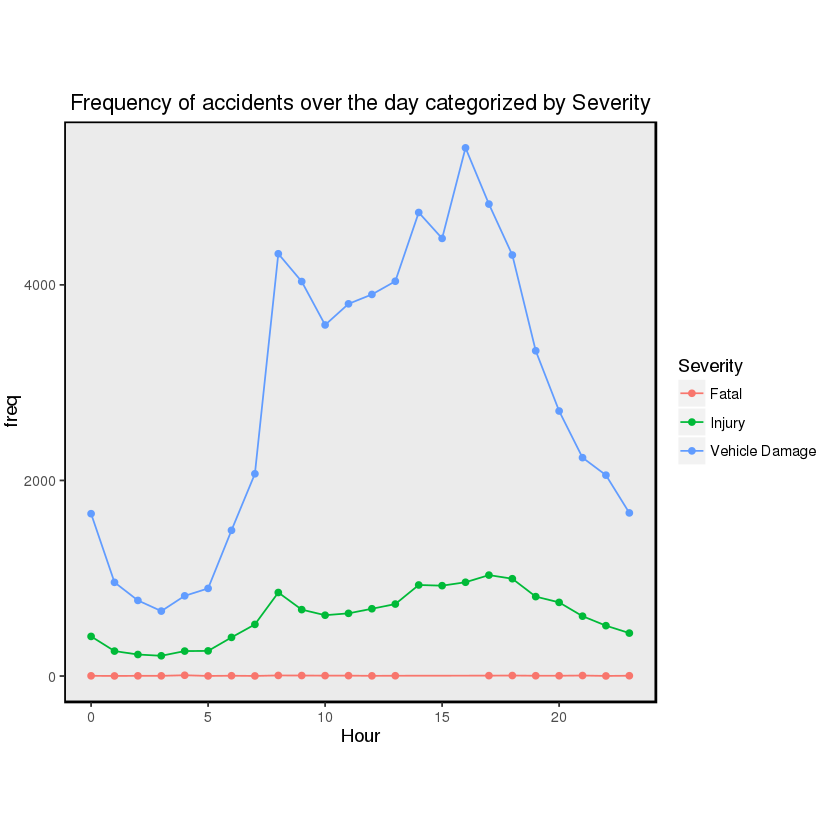

In [40]:
ggplot(data=collisionsByHour, aes(x=Hour, y=freq, group=Severity, colour=Severity)) +
    geom_line() +
    geom_point() +
    ggtitle("Frequency of accidents over the day categorized by Severity") + theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(colour = "black", fill=NA, size=1),
    plot.margin = unit(c(2, 0, 2, 0), "cm"))

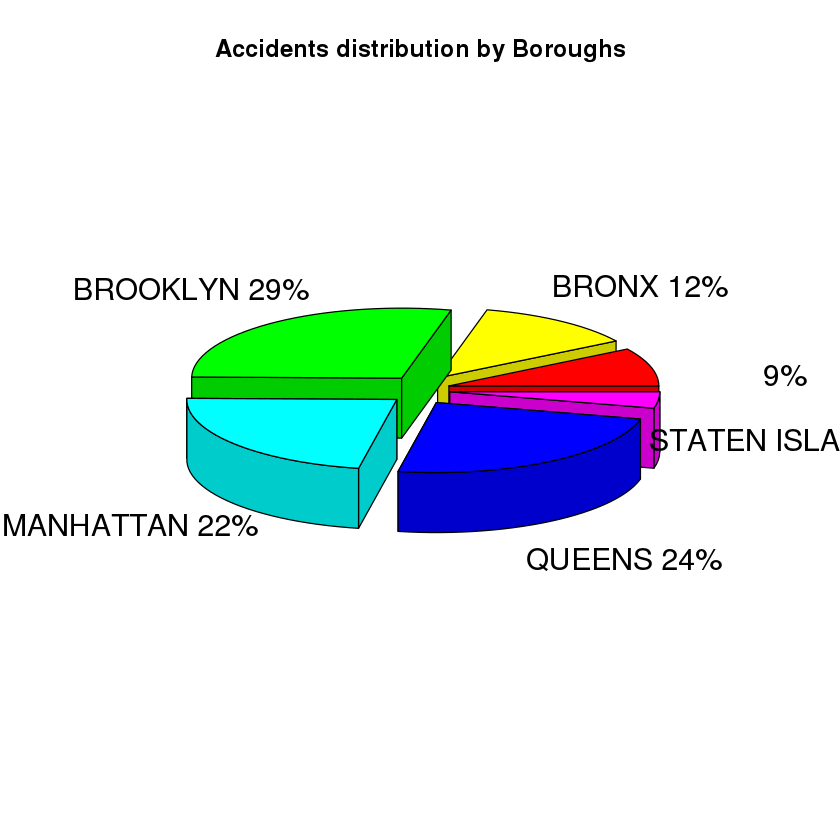

In [138]:
# 3D Exploded Pie Chart
percentage <- round(collisionsByBorough$freq/sum(collisionsByBorough$freq)*100)
lables <- paste(collisionsByBorough$Borough, percentage) # add percents to labels
lables <- paste(lables,"%",sep="") # ad % to labels 
pie3D(collisionsByBorough$freq,labels=lables,explode=0.1, main="Accidents distribution by Boroughs",radius = 0.7)

In [4]:
collisionsSDF <- read.df(sqlContext, "swift://notebooks.spark/NYPD_Motor_Vehicle_Collisions.csv", source = "com.databricks.spark.csv", header = "true")
collisionsDF <- collect(select(collisionsSDF,'CONTRIBUTING FACTOR VEHICLE 1'))
colnames(collisionsDF) <- "CONTRIBUTING_FACTOR_VEHICLE_1"
df2 <- count(collisionsDF, c('CONTRIBUTING_FACTOR_VEHICLE_1'))
df3 <- df2[rev(order(df2$freq)),]
top8 <- head(df3,8)

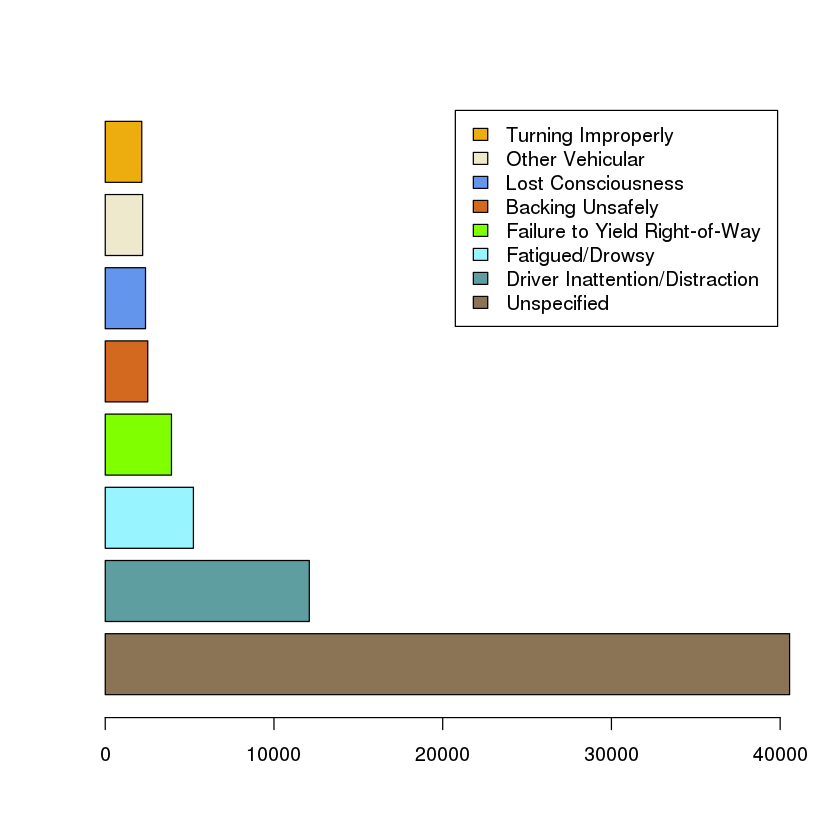

In [5]:
barplot(top8$freq, col=c("burlywood4","cadetblue","cadetblue1","chartreuse","chocolate","cornflowerblue","cornsilk2","darkgoldenrod2"), horiz=TRUE,  legend=top8$CONTRIBUTING_FACTOR_VEHICLE_1)